<a href="https://colab.research.google.com/github/aditijoshi613/Time-Series-Analysis-of-Continuous-Flow-Process/blob/main/ContinuousFlowProcess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Continuous Flow Process**


In [ ]:
from google.colab import drive   
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.diagnostic import normal_ad
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import acf, pacf
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Reshape
from keras.layers.recurrent import LSTM
from keras.models import load_model
from keras import backend
from keras.layers import Bidirectional
from tensorflow.keras.optimizers import SGD

Save the dataset.csv file at a suitable location and enter it as an argument to the function below

In [ ]:
df = pd.read_csv('drive/MyDrive/CL688Project/ContinuousFlowProcess/dataset.csv')
df.head()

,time_stamp,AmbientConditions.AmbientHumidity.U.Actual,AmbientConditions.AmbientTemperature.U.Actual,Machine1.RawMaterial.Property1,Machine1.RawMaterial.Property2,Machine1.RawMaterial.Property3,Machine1.RawMaterial.Property4,Machine1.RawMaterialFeederParameter.U.Actual,Machine1.Zone1Temperature.C.Actual,Machine1.Zone2Temperature.C.Actual,Machine1.MotorAmperage.U.Actual,Machine1.MotorRPM.C.Actual,Machine1.MaterialPressure.U.Actual,Machine1.MaterialTemperature.U.Actual,Machine1.ExitZoneTemperature.C.Actual,Machine2.RawMaterial.Property1,Machine2.RawMaterial.Property2,Machine2.RawMaterial.Property3,Machine2.RawMaterial.Property4,Machine2.RawMaterialFeederParameter.U.Actual,Machine2.Zone1Temperature.C.Actual,Machine2.Zone2Temperature.C.Actual,Machine2.MotorAmperage.U.Actual,Machine2.MotorRPM.C.Actual,Machine2.MaterialPressure.U.Actual,Machine2.MaterialTemperature.U.Actual,Machine2.ExitZoneTemperature.C.Actual,Machine3.RawMaterial.Property1,Machine3.RawMaterial.Property2,Machine3.RawMaterial.Property3,Machine3.RawMaterial.Property4,Machine3.RawMaterialFeederParameter.U.Actual,Machine3.Zone1Temperature.C.Actual,Machine3.Zone2Temperature.C.Actual,Machine3.MotorAmperage.U.Actual,Machine3.MotorRPM.C.Actual,Machine3.MaterialPressure.U.Actual,Machine3.MaterialTemperature.U.Actual,Machine3.ExitZoneTemperature.C.Actual,FirstStage.CombinerOperation.Temperature1.U.Actual,...,Machine4.Temperature4.C.Actual,Machine4.Temperature5.C.Actual,Machine4.ExitTemperature.U.Actual,Machine5.Temperature1.C.Actual,Machine5.Temperature2.C.Actual,Machine5.Temperature3.C.Actual,Machine5.Temperature4.C.Actual,Machine5.Temperature5.C.Actual,Machine5.Temperature6.C.Actual,Machine5.ExitTemperature.U.Actual,Stage2.Output.Measurement0.U.Actual,Stage2.Output.Measurement0.U.Setpoint,Stage2.Output.Measurement1.U.Actual,Stage2.Output.Measurement1.U.Setpoint,Stage2.Output.Measurement2.U.Actual,Stage2.Output.Measurement2.U.Setpoint,Stage2.Output.Measurement3.U.Actual,Stage2.Output.Measurement3.U.Setpoint,Stage2.Output.Measurement4.U.Actual,Stage2.Output.Measurement4.U.Setpoint,Stage2.Output.Measurement5.U.Actual,Stage2.Output.Measurement5.U.Setpoint,Stage2.Output.Measurement6.U.Actual,Stage2.Output.Measurement6.U.Setpoint,Stage2.Output.Measurement7.U.Actual,Stage2.Output.Measurement7.U.Setpoint,Stage2.Output.Measurement8.U.Actual,Stage2.Output.Measurement8.U.Setpoint,Stage2.Output.Measurement9.U.Actual,Stage2.Output.Measurement9.U.Setpoint,Stage2.Output.Measurement10.U.Actual,Stage2.Output.Measurement10.U.Setpoint,Stage2.Output.Measurement11.U.Actual,Stage2.Output.Measurement11.U.Setpoint,Stage2.Output.Measurement12.U.Actual,Stage2.Output.Measurement12.U.Setpoint,Stage2.Output.Measurement13.U.Actual,Stage2.Output.Measurement13.U.Setpoint,Stage2.Output.Measurement14.U.Actual,Stage2.Output.Measurement14.U.Setpoint
0,2019-03-06 10:52:33,17.24,23.53,11.54,200,963.0,247,1241.26,72.0,72.3,48.03,10.48,436.76,76.3,75.1,12.59,236,601.11,257,200.75,69.37,69.06,73.25,13.89,246.68,68.8,60.1,9.02,186,421.16,200,203.95,78.2,78.4,337.40,13.50,263.71,65.3,65.0,99.1,...,21.0,260.0,35.0,309.8,289.9,263.9,238.6,245.0,66.1,50.0,0.0,12.05,0.0,11.71,0.0,11,0.0,20.73,0.0,31.36,0.0,2.71,0.0,0.01,0.0,2.75,0.0,19.39,0.0,16.47,0.0,7.93,0.0,5.65,0.0,1.85,0.0,2.89,0.0,11.71
1,2019-03-06 10:52:34,17.24,23.53,11.54,200,963.0,247,1246.09,72.0,72.3,48.03,10.48,436.77,76.3,75.1,12.59,236,601.11,257,220.16,69.35,69.05,73.19,13.89,246.02,69.0,60.0,9.02,186,421.16,200,213.36,78.1,78.4,341.85,13.59,262.88,65.3,65.0,99.1,...,23.0,263.0,35.0,309.8,289.9,263.9,238.6,245.0,66.1,49.8,0.0,12.05,0.0,11.71,0.0,11,0.0,20.73,0.0,31.36,0.0,2.71,0.0,0.01,0.0,2.75,0.0,19.39,0.0,16.47,0.0,7.93,0.0,5.65,0.0,1.85,0.0,2.89,0.0,11.71
2,2019-03-06 10:52:35,17.24,23.53,11.54,200,963.0,247,1246.29,72.0,72.3,48.16,10.48,425.46,76.3,75.1,12.59,236,601.11,257,216.84,69.37,69.07,73.19,13.85,247.18,68.9,60.0,9.02,186,421.16,200,225.25,78.1,78.5,338.71,14.00,262.63,65.3,65.0,99.6,...,22.0,266.0,35.0,309.8,289.9,263.9,238.6,245.0,66.1,

We will consider the measurement 0 of stage 1 output of the given dynamic process as our target/dependent variable. There are 41 input/independent variables that influence this output. Furthermore, this is a time series data.

In [ ]:
df_stage1 = df.iloc[:,:44]
df_stage1

,time_stamp,AmbientConditions.AmbientHumidity.U.Actual,AmbientConditions.AmbientTemperature.U.Actual,Machine1.RawMaterial.Property1,Machine1.RawMaterial.Property2,Machine1.RawMaterial.Property3,Machine1.RawMaterial.Property4,Machine1.RawMaterialFeederParameter.U.Actual,Machine1.Zone1Temperature.C.Actual,Machine1.Zone2Temperature.C.Actual,Machine1.MotorAmperage.U.Actual,Machine1.MotorRPM.C.Actual,Machine1.MaterialPressure.U.Actual,Machine1.MaterialTemperature.U.Actual,Machine1.ExitZoneTemperature.C.Actual,Machine2.RawMaterial.Property1,Machine2.RawMaterial.Property2,Machine2.RawMaterial.Property3,Machine2.RawMaterial.Property4,Machine2.RawMaterialFeederParameter.U.Actual,Machine2.Zone1Temperature.C.Actual,Machine2.Zone2Temperature.C.Actual,Machine2.MotorAmperage.U.Actual,Machine2.MotorRPM.C.Actual,Machine2.MaterialPressure.U.Actual,Machine2.MaterialTemperature.U.Actual,Machine2.ExitZoneTemperature.C.Actual,Machine3.RawMaterial.Property1,Machine3.RawMaterial.Property2,Machine3.RawMaterial.Property3,Machine3.RawMaterial.Property4,Machine3.RawMaterialFeederParameter.U.Actual,Machine3.Zone1Temperature.C.Actual,Machine3.Zone2Temperature.C.Actual,Machine3.MotorAmperage.U.Actual,Machine3.MotorRPM.C.Actual,Machine3.MaterialPressure.U.Actual,Machine3.MaterialTemperature.U.Actual,Machine3.ExitZoneTemperature.C.Actual,FirstStage.CombinerOperation.Temperature1.U.Actual,FirstStage.CombinerOperation.Temperature2.U.Actual,FirstStage.CombinerOperation.Temperature3.C.Actual,Stage1.Output.Measurement0.U.Actual,Stage1.Output.Measurement0.U.Setpoint
0,2019-03-06 10:52:33,17.24,23.53,11.54,200,963.00,247,1241.26,72.0,72.3,48.03,10.48,436.76,76.3,75.1,12.59,236,601.11,257,200.75,69.37,69.06,73.25,13.89,246.68,68.8,60.1,9.02,186,421.16,200,203.95,78.2,78.4,337.40,13.50,263.71,65.3,65.0,99.1,108.2,80.0,12.72,13.75
1,2019-03-06 10:52:34,17.24,23.53,11.54,200,963.00,247,1246.09,72.0,72.3,48.03,10.48,436.77,76.3,75.1,12.59,236,601.11,257,220.16,69.35,69.05,73.19,13.89,246.02,69.0,60.0,9.02,186,421.16,200,213.36,78.1,78.4,341.85,13.59,262.88,65.3,65.0,99.1,109.2,80.0,12.34,13.75
2,2019-03-06 10:52:35,17.24,23.53,11.54,200,963.00,247,1246.29,72.0,72.3,48.16,10.48,425.46,76.3,75.1,12.59,236,601.11,257,216.84,69.37,69.07,73.19,13.85,247.18,68.9,60.0,9.02,186,421.16,200,225.25,78.1,78.5,338.71,14.00,262.63,65.3,65.0,99.6,111.0,80.0,12.34,13.75
3,2019-03-06 10:52:36,17.24,23.53,11.54,200,963.00,247,1247.59,72.0,72.3,48.57,10.48,437.01,76.3,75.1,12.59,236,601.11,257,208.61,69.38,69.08,72.81,13.90,249.92,69.1,59.9,9.02,186,421.16,200,213.99,78.1,78.5,339.15,13.67,262.22,65.4,65.0,99.6,109.2,80.0,12.34,13.75
4,2019-03-06 10:52:37,17.24,23.53,11.54,200,963.00,247,1252.83,72.1,72.4,48.57,10.48,425.18,76.4,75.1,12.59,236,601.11,257,212.31,69.40,69.07,73.00,13.89,250.58,68.9,59.9,9.02,186,421.16,200,200.86,78.0,78.5,337.05,13.72,262.17,65.4,65.0,99.6,109.8,80.0,12.29,13.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14083,2019-03-06 14:47:16,13.84,24.43,12.22,201,1048.06,252,1263.76,72.0,71.8,73.46,12.21,424.53,83.7,80.0,12.85,241,556.70,256,208.51,69.00,69.09,73.44,13.87,227.02,77.2,60.0,8.83,221,433.18,205,195.22,78.0,78.1,337.50,12.04,248.18,74.9,64.9,115.4,106.5,80.0,12.61,13.75
14084,2019-03-06 14:47:17,13.84,24.43,12.22,201,1048.06,252,1255.42,72.0,71.8,73.32,12.17,426.73,83.7,80.0,12.85,241,556.70,256,224.93,68.99,69.06,73.31,13.86,223.55,77.2,60.0,8.83,221,433.18,205,225.15,78.0,78.1,342.43,12.32,248.20,74.9,64.9,118.1,107.4,80.0,12.61,13.75
14085,2019-03-06 14:47:18,13.84,24.43,12.22,201,1048.06,252,1257.52,72.0,71.8,73.59,12.14,429.77,83.7,80.0,12.85,241,556.70,256,207.35,68.97,69.05,73.94,13.85,222.52,77.2,60.0,8.83,221,433.18,205,210.46,78.0,78.1,334.89,12.18,248.92,74.9,64.9,118.1,108.0,80.0,12.61,13.75
14086,2019-03-06 14:47:19,13.84,24.43,12.22,201,1048.06,252,1261.99,72.0,71.9,74.40,12.21,431.36,83.7,80.0,12.85,241,55

# **Data Pre-processing**

Check for the null values and drop such rows.

In [ ]:
df_stage1.isna()

,time_stamp,AmbientConditions.AmbientHumidity.U.Actual,AmbientConditions.AmbientTemperature.U.Actual,Machine1.RawMaterial.Property1,Machine1.RawMaterial.Property2,Machine1.RawMaterial.Property3,Machine1.RawMaterial.Property4,Machine1.RawMaterialFeederParameter.U.Actual,Machine1.Zone1Temperature.C.Actual,Machine1.Zone2Temperature.C.Actual,Machine1.MotorAmperage.U.Actual,Machine1.MotorRPM.C.Actual,Machine1.MaterialPressure.U.Actual,Machine1.MaterialTemperature.U.Actual,Machine1.ExitZoneTemperature.C.Actual,Machine2.RawMaterial.Property1,Machine2.RawMaterial.Property2,Machine2.RawMaterial.Property3,Machine2.RawMaterial.Property4,Machine2.RawMaterialFeederParameter.U.Actual,Machine2.Zone1Temperature.C.Actual,Machine2.Zone2Temperature.C.Actual,Machine2.MotorAmperage.U.Actual,Machine2.MotorRPM.C.Actual,Machine2.MaterialPressure.U.Actual,Machine2.MaterialTemperature.U.Actual,Machine2.ExitZoneTemperature.C.Actual,Machine3.RawMaterial.Property1,Machine3.RawMaterial.Property2,Machine3.RawMaterial.Property3,Machine3.RawMaterial.Property4,Machine3.RawMaterialFeederParameter.U.Actual,Machine3.Zone1Temperature.C.Actual,Machine3.Zone2Temperature.C.Actual,Machine3.MotorAmperage.U.Actual,Machine3.MotorRPM.C.Actual,Machine3.MaterialPressure.U.Actual,Machine3.MaterialTemperature.U.Actual,Machine3.ExitZoneTemperature.C.Actual,FirstStage.CombinerOperation.Temperature1.U.Actual,FirstStage.CombinerOperation.Temperature2.U.Actual,FirstStage.CombinerOperation.Temperature3.C.Actual,Stage1.Output.Measurement0.U.Actual,Stage1.Output.Measurement0.U.Setpoint
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14083,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
14084,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
14085,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
14086,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False

In [ ]:
df_stage1 = df_stage1.dropna(axis = 0, how='any')
df_stage1

,time_stamp,AmbientConditions.AmbientHumidity.U.Actual,AmbientConditions.AmbientTemperature.U.Actual,Machine1.RawMaterial.Property1,Machine1.RawMaterial.Property2,Machine1.RawMaterial.Property3,Machine1.RawMaterial.Property4,Machine1.RawMaterialFeederParameter.U.Actual,Machine1.Zone1Temperature.C.Actual,Machine1.Zone2Temperature.C.Actual,Machine1.MotorAmperage.U.Actual,Machine1.MotorRPM.C.Actual,Machine1.MaterialPressure.U.Actual,Machine1.MaterialTemperature.U.Actual,Machine1.ExitZoneTemperature.C.Actual,Machine2.RawMaterial.Property1,Machine2.RawMaterial.Property2,Machine2.RawMaterial.Property3,Machine2.RawMaterial.Property4,Machine2.RawMaterialFeederParameter.U.Actual,Machine2.Zone1Temperature.C.Actual,Machine2.Zone2Temperature.C.Actual,Machine2.MotorAmperage.U.Actual,Machine2.MotorRPM.C.Actual,Machine2.MaterialPressure.U.Actual,Machine2.MaterialTemperature.U.Actual,Machine2.ExitZoneTemperature.C.Actual,Machine3.RawMaterial.Property1,Machine3.RawMaterial.Property2,Machine3.RawMaterial.Property3,Machine3.RawMaterial.Property4,Machine3.RawMaterialFeederParameter.U.Actual,Machine3.Zone1Temperature.C.Actual,Machine3.Zone2Temperature.C.Actual,Machine3.MotorAmperage.U.Actual,Machine3.MotorRPM.C.Actual,Machine3.MaterialPressure.U.Actual,Machine3.MaterialTemperature.U.Actual,Machine3.ExitZoneTemperature.C.Actual,FirstStage.CombinerOperation.Temperature1.U.Actual,FirstStage.CombinerOperation.Temperature2.U.Actual,FirstStage.CombinerOperation.Temperature3.C.Actual,Stage1.Output.Measurement0.U.Actual,Stage1.Output.Measurement0.U.Setpoint
0,2019-03-06 10:52:33,17.24,23.53,11.54,200,963.00,247,1241.26,72.0,72.3,48.03,10.48,436.76,76.3,75.1,12.59,236,601.11,257,200.75,69.37,69.06,73.25,13.89,246.68,68.8,60.1,9.02,186,421.16,200,203.95,78.2,78.4,337.40,13.50,263.71,65.3,65.0,99.1,108.2,80.0,12.72,13.75
1,2019-03-06 10:52:34,17.24,23.53,11.54,200,963.00,247,1246.09,72.0,72.3,48.03,10.48,436.77,76.3,75.1,12.59,236,601.11,257,220.16,69.35,69.05,73.19,13.89,246.02,69.0,60.0,9.02,186,421.16,200,213.36,78.1,78.4,341.85,13.59,262.88,65.3,65.0,99.1,109.2,80.0,12.34,13.75
2,2019-03-06 10:52:35,17.24,23.53,11.54,200,963.00,247,1246.29,72.0,72.3,48.16,10.48,425.46,76.3,75.1,12.59,236,601.11,257,216.84,69.37,69.07,73.19,13.85,247.18,68.9,60.0,9.02,186,421.16,200,225.25,78.1,78.5,338.71,14.00,262.63,65.3,65.0,99.6,111.0,80.0,12.34,13.75
3,2019-03-06 10:52:36,17.24,23.53,11.54,200,963.00,247,1247.59,72.0,72.3,48.57,10.48,437.01,76.3,75.1,12.59,236,601.11,257,208.61,69.38,69.08,72.81,13.90,249.92,69.1,59.9,9.02,186,421.16,200,213.99,78.1,78.5,339.15,13.67,262.22,65.4,65.0,99.6,109.2,80.0,12.34,13.75
4,2019-03-06 10:52:37,17.24,23.53,11.54,200,963.00,247,1252.83,72.1,72.4,48.57,10.48,425.18,76.4,75.1,12.59,236,601.11,257,212.31,69.40,69.07,73.00,13.89,250.58,68.9,59.9,9.02,186,421.16,200,200.86,78.0,78.5,337.05,13.72,262.17,65.4,65.0,99.6,109.8,80.0,12.29,13.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14083,2019-03-06 14:47:16,13.84,24.43,12.22,201,1048.06,252,1263.76,72.0,71.8,73.46,12.21,424.53,83.7,80.0,12.85,241,556.70,256,208.51,69.00,69.09,73.44,13.87,227.02,77.2,60.0,8.83,221,433.18,205,195.22,78.0,78.1,337.50,12.04,248.18,74.9,64.9,115.4,106.5,80.0,12.61,13.75
14084,2019-03-06 14:47:17,13.84,24.43,12.22,201,1048.06,252,1255.42,72.0,71.8,73.32,12.17,426.73,83.7,80.0,12.85,241,556.70,256,224.93,68.99,69.06,73.31,13.86,223.55,77.2,60.0,8.83,221,433.18,205,225.15,78.0,78.1,342.43,12.32,248.20,74.9,64.9,118.1,107.4,80.0,12.61,13.75
14085,2019-03-06 14:47:18,13.84,24.43,12.22,201,1048.06,252,1257.52,72.0,71.8,73.59,12.14,429.77,83.7,80.0,12.85,241,556.70,256,207.35,68.97,69.05,73.94,13.85,222.52,77.2,60.0,8.83,221,433.18,205,210.46,78.0,78.1,334.89,12.18,248.92,74.9,64.9,118.1,108.0,80.0,12.61,13.75
14086,2019-03-06 14:47:19,13.84,24.43,12.22,201,1048.06,252,1261.99,72.0,71.9,74.40,12.21,431.36,83.7,80.0,12.85,241,55

Columns of the dataframe are as follows:

In [ ]:
df_stage1.columns

Note on variable naming conventions

~.C.Setpoint	-	Setpoint for Controlled variable

~.C.Actual	-	Actual value of Controlled variable

~.U.Actual	-	Actual value of Uncontrolled variable

Others	-	Environmental or raw material variables, States / events, etc.

0	- Time stamp

1 to 2 - Factory ambient conditions

3	to 6 - First stage, Machine 1, raw material properties (material going in to Machine 1)

7	to 14 - First stage, Machine 1 process variables

15 to 18 - First stage, Machine 2, raw material properties (material going in to Machine 2)

19 to 26 - First stage, Machine 2 process variables

27 to 30 - First stage, Machine 3, raw material properties (material going in to Machine 3)

31 to 38 - First stage, Machine 3 process variables

39 to 41 - Combiner stage process parameters. Here we combine the outputs from Machines 1, 2, and 3.

42 - Measurement 0 of Stage one output

43 - Set point of Measurement 0 of Stage one output

In [ ]:
df_stage1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14088 entries, 0 to 14087
Data columns (total 44 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   time_stamp                                          14088 non-null  object 
 1   AmbientConditions.AmbientHumidity.U.Actual          14088 non-null  float64
 2   AmbientConditions.AmbientTemperature.U.Actual       14088 non-null  float64
 3   Machine1.RawMaterial.Property1                      14088 non-null  float64
 4   Machine1.RawMaterial.Property2                      14088 non-null  int64  
 5   Machine1.RawMaterial.Property3                      14088 non-null  float64
 6   Machine1.RawMaterial.Property4                      14088 non-null  int64  
 7   Machine1.RawMaterialFeederParameter.U.Actual        14088 non-null  float64
 8   Machine1.Zone1Temperature.C.Actual                  14088 non-null  float64


In [ ]:
df_stage1.describe()

,AmbientConditions.AmbientHumidity.U.Actual,AmbientConditions.AmbientTemperature.U.Actual,Machine1.RawMaterial.Property1,Machine1.RawMaterial.Property2,Machine1.RawMaterial.Property3,Machine1.RawMaterial.Property4,Machine1.RawMaterialFeederParameter.U.Actual,Machine1.Zone1Temperature.C.Actual,Machine1.Zone2Temperature.C.Actual,Machine1.MotorAmperage.U.Actual,Machine1.MotorRPM.C.Actual,Machine1.MaterialPressure.U.Actual,Machine1.MaterialTemperature.U.Actual,Machine1.ExitZoneTemperature.C.Actual,Machine2.RawMaterial.Property1,Machine2.RawMaterial.Property2,Machine2.RawMaterial.Property3,Machine2.RawMaterial.Property4,Machine2.RawMaterialFeederParameter.U.Actual,Machine2.Zone1Temperature.C.Actual,Machine2.Zone2Temperature.C.Actual,Machine2.MotorAmperage.U.Actual,Machine2.MotorRPM.C.Actual,Machine2.MaterialPressure.U.Actual,Machine2.MaterialTemperature.U.Actual,Machine2.ExitZoneTemperature.C.Actual,Machine3.RawMaterial.Property1,Machine3.RawMaterial.Property2,Machine3.RawMaterial.Property3,Machine3.RawMaterial.Property4,Machine3.RawMaterialFeederParameter.U.Actual,Machine3.Zone1Temperature.C.Actual,Machine3.Zone2Temperature.C.Actual,Machine3.MotorAmperage.U.Actual,Machine3.MotorRPM.C.Actual,Machine3.MaterialPressure.U.Actual,Machine3.MaterialTemperature.U.Actual,Machine3.ExitZoneTemperature.C.Actual,FirstStage.CombinerOperation.Temperature1.U.Actual,FirstStage.CombinerOperation.Temperature2.U.Actual,FirstStage.CombinerOperation.Temperature3.C.Actual,Stage1.Output.Measurement0.U.Actual,Stage1.Output.Measurement0.U.Setpoint
count,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000
mean,15.330759,23.843635,11.851256,205.676320,951.679815,248.868896,1242.764276,72.013330,72.013106,70.333111,11.072094,409.006724,81.470000,75.966161,12.793397,239.911485,566.368191,256.217703,202.585311,68.996904,69.101083,73.398762,13.896803,226.122234,76.812278,60.001331,9.090484,205.647217,425.014412,203.038756,202.379555,78.008251,78.004958,345.111591,13.269664,246.750253,74.140265,65.008232,108.917970,84.898323,80.003714,12.896919,13.695344
std,1.188993,0.373535,0.510309,11.606324,126.662010,3.297820,95.845946,0.063183,0.406313,5.525217,0.635172,20.478385,0.930562,2.059027,0.107302,2.063495,18.327964,0.412699,15.110901,0.057020,0.109114,0.396051,0.029167,3.106395,0.855002,0.162070,0.396605,16.319764,9.559928,2.177618,15.653649,0.076826,0.114822,9.077714,0.434594,6.122104,2.058298,0.062440,5.669857,18.579319,0.118327,0.934228,0.865212
min,13.840000,23.020000,11.540000,200.000000,601.110000,247.000000,231.300000,71.900000,71.300000,44.400000,10.390000,359.470000,76.300000,69.700000,12.590000,236.000000,556.700000,256.000000,0.000000,68.670000,67.780000,71.560000,13.820000,218.870000,68.800000,59.598710,8.830000,186.000000,408.970000,200.000000,0.000000,77.278364,77.700000,321.250000,11.960000,235.060000,65.300000,64.800000,45.300000,53.300000,79.600000,0.000000,0.000000
25%,14.040000,23.530000,11.540000,200.000000,963.000000,247.000000,1257.170000,72.000000,71.600000,68.880000,10.520000,408.950000,81.000000,75.000000,12.850000,241.000000,556.700000,256.000000,194.160000,68.980000,69.070000,73.190000,13.870000,223.880000,76.900000,59.900000,8.830000,186.000000,421.160000,200.000000,193.980000,78.000000,77.900000,338.920000,12.970000,242.810000,73.600000,65.000000,104.200000,69.000000,80.000000,12.890000,13.750000
50%,15.120000,23.930000,11.540000,200.000000,963.000000,247.000000,1264.440000,72.000000,72.000000,71.980000,10.730000,416.960000,81.300000,75.0

Plot output versus time stamp

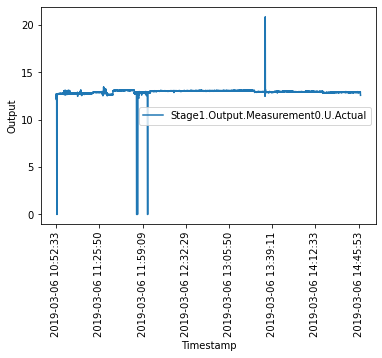

In [ ]:
def plot_output_vs_time(df,i):  
  df.plot(x='time_stamp', y=df.columns.values.tolist()[i])
  plt.xticks(rotation = 90)
  plt.xlabel('Timestamp') 
  plt.ylabel('Output')
  plt.show()
plot_output_vs_time(df_stage1,42)

We can see that our data is mean-centred. Though it is not white noise since the mean is not 0.

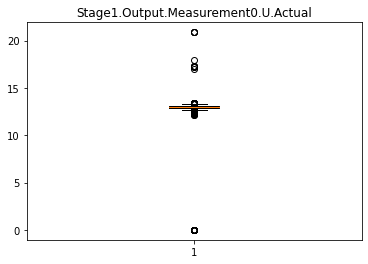

In [ ]:
def box_plot(df,i):
  plt.boxplot(df.iloc[:,i])
  plt.title(df.columns.values.tolist()[i])
  plt.show()
box_plot(df_stage1,42)

The box plot shows a significant number of outliers. We will remove those by using the concept of interquartile range and replace them with mean.

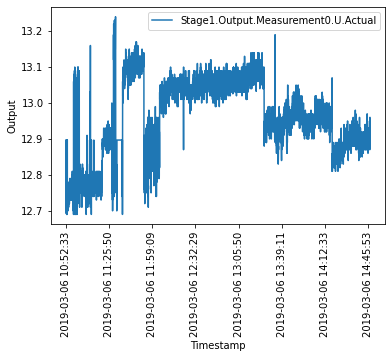

In [ ]:
q1 = np.percentile(df_stage1['Stage1.Output.Measurement0.U.Actual'],25)
q3 = np.percentile(df_stage1['Stage1.Output.Measurement0.U.Actual'],75)
boolean_condition = (df_stage1['Stage1.Output.Measurement0.U.Actual'] < q1 - (q3-q1)*1.3) | (df_stage1['Stage1.Output.Measurement0.U.Actual'] > q3 + (q3-q1)*1.3)
column_name = 'Stage1.Output.Measurement0.U.Actual'
new_value = np.mean(df_stage1['Stage1.Output.Measurement0.U.Actual'])

df_stage1.loc[boolean_condition, column_name] = new_value
df_stage1.head()
plot_output_vs_time(df_stage1,42)

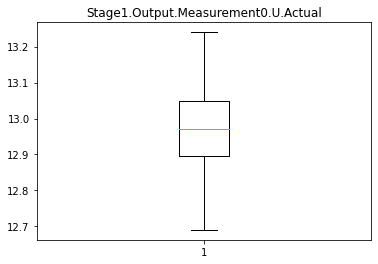

In [ ]:
box_plot(df_stage1,42)

Now, we see no outliers in the box plot.

We shall examine if there is a feedback loop in the system, i.e., if the output depends on the setpoint

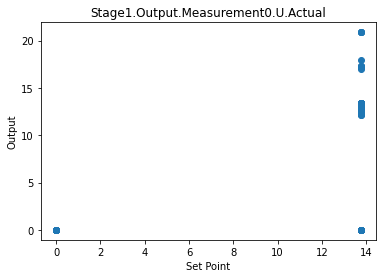

In [ ]:
def plot_setpoint_vs_output(i):  
  plt.scatter(df_stage1.iloc[:,i+1],df_stage1.iloc[:,i])
  plt.xlabel('Set Point')
  plt.ylabel('Output')
  plt.title(df_stage1.columns.values.tolist()[i])
  plt.show() 
plot_setpoint_vs_output(42)

In [ ]:
df_stage1[df_stage1['Stage1.Output.Measurement0.U.Setpoint']==0].shape

(56, 44)

We observe that the setpoint is constant for a large part of the dataset. The only exception occurs when the output and setpoint both become 0 (56 data points). Such points can be treated as exceptions when the signal may not be recorded by the sensors. We can conclude that there is no feedback loop in the system. Hence, set point won't serve as an input variable and we shall remove it from the dataframe.

In [ ]:
df_stage1 = df_stage1.drop(['Stage1.Output.Measurement0.U.Setpoint'],axis = 1)

In [ ]:
df_stage1.shape

(14088, 43)

**Stationarity Test**

We shall adopt the Augmented Dickey-Fuller Test for judging the stationarity of our time series.

In [ ]:
def ADF_Test(df,df_adf,i):	
	series = df.iloc[:,i]
	X = series.values
	result = adfuller(X)
	df_adf_i = pd.DataFrame({'Output':df.columns.values.tolist()[i],'ADF Statistic':result[0],'p-value':result[1],'CriticalValues':result[4]})
	df_adf = df_adf.append(df_adf_i,ignore_index = True)
	return df_adf

In [ ]:
df_adf = pd.DataFrame()
df_adf = ADF_Test(df_stage1,df_adf,42)
df_adf

,Output,ADF Statistic,p-value,CriticalValues
0,Stage1.Output.Measurement0.U.Actual,-3.633535,0.005151,-3.430816
1,Stage1.Output.Measurement0.U.Actual,-3.633535,0.005151,-2.566880
2,Stage1.Output.Measurement0.U.Actual,-3.633535,0.005151,-2.861746


This suggests that we can reject the null hypothesis with a significance level of **less than 1%** (i.e. a low probability that the result is a statistical fluke).

A p-value < 0.05 suggests that we will reject the null hypothesis Rejecting the null hypothesis means that the process has no unit root, and in turn that the time series is **stationary** or does not have time-dependent structure.

**Box-cox transforms**

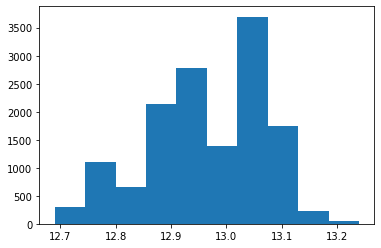

In [ ]:
plt.hist(df_stage1['Stage1.Output.Measurement0.U.Actual'])
plt.show()

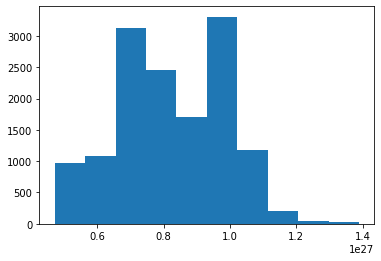

In [ ]:
fitted_m0, optimal_lambda = stats.boxcox(df_stage1['Stage1.Output.Measurement0.U.Actual'])
plt.hist(fitted_m0)
plt.show()

In [ ]:
optimal_lambda

25.44676374478295

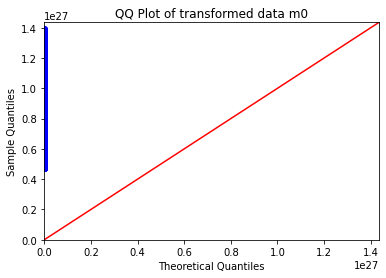

In [ ]:
sm.qqplot(fitted_m0, line ='45')
plt.title('QQ Plot of transformed data m0')
plt.show()

An optimal lambda of 24.45 is obtained.

The histogram and qq-plot show that the box-cox transform doesn't work well with this data, i.e., normality of the data is not ensured after transformation.

In [ ]:
print(pd.infer_freq(df_stage1['time_stamp']))

None


Time stamp is set as the index for subsequent decomposition of time series.

In [ ]:
df_stage1_time_index = df_stage1.drop_duplicates(subset='time_stamp')
df_stage1_time_index['time_stamp'] = pd.to_datetime(df_stage1_time_index['time_stamp'])
df_stage1_time_index = df_stage1_time_index.set_index(['time_stamp'])
df_stage1_time_index.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,AmbientConditions.AmbientHumidity.U.Actual,AmbientConditions.AmbientTemperature.U.Actual,Machine1.RawMaterial.Property1,Machine1.RawMaterial.Property2,Machine1.RawMaterial.Property3,Machine1.RawMaterial.Property4,Machine1.RawMaterialFeederParameter.U.Actual,Machine1.Zone1Temperature.C.Actual,Machine1.Zone2Temperature.C.Actual,Machine1.MotorAmperage.U.Actual,Machine1.MotorRPM.C.Actual,Machine1.MaterialPressure.U.Actual,Machine1.MaterialTemperature.U.Actual,Machine1.ExitZoneTemperature.C.Actual,Machine2.RawMaterial.Property1,Machine2.RawMaterial.Property2,Machine2.RawMaterial.Property3,Machine2.RawMaterial.Property4,Machine2.RawMaterialFeederParameter.U.Actual,Machine2.Zone1Temperature.C.Actual,Machine2.Zone2Temperature.C.Actual,Machine2.MotorAmperage.U.Actual,Machine2.MotorRPM.C.Actual,Machine2.MaterialPressure.U.Actual,Machine2.MaterialTemperature.U.Actual,Machine2.ExitZoneTemperature.C.Actual,Machine3.RawMaterial.Property1,Machine3.RawMaterial.Property2,Machine3.RawMaterial.Property3,Machine3.RawMaterial.Property4,Machine3.RawMaterialFeederParameter.U.Actual,Machine3.Zone1Temperature.C.Actual,Machine3.Zone2Temperature.C.Actual,Machine3.MotorAmperage.U.Actual,Machine3.MotorRPM.C.Actual,Machine3.MaterialPressure.U.Actual,Machine3.MaterialTemperature.U.Actual,Machine3.ExitZoneTemperature.C.Actual,FirstStage.CombinerOperation.Temperature1.U.Actual,FirstStage.CombinerOperation.Temperature2.U.Actual,FirstStage.CombinerOperation.Temperature3.C.Actual,Stage1.Output.Measurement0.U.Actual
time_stamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-03-06 10:52:33,17.24,23.53,11.54,200,963.0,247,1241.26,72.0,72.3,48.03,10.48,436.76,76.3,75.1,12.59,236,601.11,257,200.75,69.37,69.06,73.25,13.89,246.68,68.8,60.1,9.02,186,421.16,200,203.95,78.2,78.4,337.40,13.50,263.71,65.3,65.0,99.1,108.2,80.0,12.720000
2019-03-06 10:52:34,17.24,23.53,11.54,200,963.0,247,1246.09,72.0,72.3,48.03,10.48,436.77,76.3,75.1,12.59,236,601.11,257,220.16,69.35,69.05,73.19,13.89,246.02,69.0,60.0,9.02,186,421.16,200,213.36,78.1,78.4,341.85,13.59,262.88,65.3,65.0,99.1,109.2,80.0,12.896919
2019-03-06 10:52:35,17.24,23.53,11.54,200,963.0,247,1246.29,72.0,72.3,48.16,10.48,425.46,76.3,75.1,12.59,236,601.11,257,216.84,69.37,69.07,73.19,13.85,247.18,68.9,60.0,9.02,186,421.16,200,225.25,78.1,78.5,338.71,14.00,262.63,65.3,65.0,99.6,111.0,80.0,12.896919
2019-03-06 10:52:36,17.24,23.53,11.54,200,963.0,247,1247.59,72.0,72.3,48.57,10.48,437.01,76.3,75.1,12.59,236,601.11,257,208.61,69.38,69.08,72.81,13.90,249.92,69.1,59.9,9.02,186,421.16,200,213.99,78.1,78.5,339.15,13.67,262.22,65.4,65.0,99.6,109.2,80.0,12.896919
2019-03-06 10:52:37,17.24,23.53,11.54,200,963.0,247,1252.83,72.1,72.4,48.57,10.48,425.18,76.4,75.1,12.59,236,601.11,257,212.31,69.40,69.07,73.00,13.89,250.58,68.9,59.9,9.02,186,421.16,200,200.86,78.0,78.5,337.05,13.72,262.17,65.4,65.0,99.6,109.8,80.0,12.896919


To ensure uniform frequency across the dataset, it is set to 1 second

In [ ]:
df_stage1_time_index = df_stage1_time_index.asfreq('1S')
print(pd.infer_freq(df_stage1_time_index))
df_stage1_time_index.head()

None


,AmbientConditions.AmbientHumidity.U.Actual,AmbientConditions.AmbientTemperature.U.Actual,Machine1.RawMaterial.Property1,Machine1.RawMaterial.Property2,Machine1.RawMaterial.Property3,Machine1.RawMaterial.Property4,Machine1.RawMaterialFeederParameter.U.Actual,Machine1.Zone1Temperature.C.Actual,Machine1.Zone2Temperature.C.Actual,Machine1.MotorAmperage.U.Actual,Machine1.MotorRPM.C.Actual,Machine1.MaterialPressure.U.Actual,Machine1.MaterialTemperature.U.Actual,Machine1.ExitZoneTemperature.C.Actual,Machine2.RawMaterial.Property1,Machine2.RawMaterial.Property2,Machine2.RawMaterial.Property3,Machine2.RawMaterial.Property4,Machine2.RawMaterialFeederParameter.U.Actual,Machine2.Zone1Temperature.C.Actual,Machine2.Zone2Temperature.C.Actual,Machine2.MotorAmperage.U.Actual,Machine2.MotorRPM.C.Actual,Machine2.MaterialPressure.U.Actual,Machine2.MaterialTemperature.U.Actual,Machine2.ExitZoneTemperature.C.Actual,Machine3.RawMaterial.Property1,Machine3.RawMaterial.Property2,Machine3.RawMaterial.Property3,Machine3.RawMaterial.Property4,Machine3.RawMaterialFeederParameter.U.Actual,Machine3.Zone1Temperature.C.Actual,Machine3.Zone2Temperature.C.Actual,Machine3.MotorAmperage.U.Actual,Machine3.MotorRPM.C.Actual,Machine3.MaterialPressure.U.Actual,Machine3.MaterialTemperature.U.Actual,Machine3.ExitZoneTemperature.C.Actual,FirstStage.CombinerOperation.Temperature1.U.Actual,FirstStage.CombinerOperation.Temperature2.U.Actual,FirstStage.CombinerOperation.Temperature3.C.Actual,Stage1.Output.Measurement0.U.Actual
time_stamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-03-06 10:52:33,17.24,23.53,11.54,200.0,963.0,247.0,1241.26,72.0,72.3,48.03,10.48,436.76,76.3,75.1,12.59,236.0,601.11,257.0,200.75,69.37,69.06,73.25,13.89,246.68,68.8,60.1,9.02,186.0,421.16,200.0,203.95,78.2,78.4,337.40,13.50,263.71,65.3,65.0,99.1,108.2,80.0,12.720000
2019-03-06 10:52:34,17.24,23.53,11.54,200.0,963.0,247.0,1246.09,72.0,72.3,48.03,10.48,436.77,76.3,75.1,12.59,236.0,601.11,257.0,220.16,69.35,69.05,73.19,13.89,246.02,69.0,60.0,9.02,186.0,421.16,200.0,213.36,78.1,78.4,341.85,13.59,262.88,65.3,65.0,99.1,109.2,80.0,12.896919
2019-03-06 10:52:35,17.24,23.53,11.54,200.0,963.0,247.0,1246.29,72.0,72.3,48.16,10.48,425.46,76.3,75.1,12.59,236.0,601.11,257.0,216.84,69.37,69.07,73.19,13.85,247.18,68.9,60.0,9.02,186.0,421.16,200.0,225.25,78.1,78.5,338.71,14.00,262.63,65.3,65.0,99.6,111.0,80.0,12.896919
2019-03-06 10:52:36,17.24,23.53,11.54,200.0,963.0,247.0,1247.59,72.0,72.3,48.57,10.48,437.01,76.3,75.1,12.59,236.0,601.11,257.0,208.61,69.38,69.08,72.81,13.90,249.92,69.1,59.9,9.02,186.0,421.16,200.0,213.99,78.1,78.5,339.15,13.67,262.22,65.4,65.0,99.6,109.2,80.0,12.896919
2019-03-06 10:52:37,17.24,23.53,11.54,200.0,963.0,247.0,1252.83,72.1,72.4,48.57,10.48,425.18,76.4,75.1,12.59,236.0,601.11,257.0,212.31,69.40,69.07,73.00,13.89,250.58,68.9,59.9,9.02,186.0,421.16,200.0,200.86,78.0,78.5,337.05,13.72,262.17,65.4,65.0,99.6,109.8,80.0,12.896919


Any null values from the time series are replaced by interpolation.

In [ ]:
df_stage1_time_index['Stage1.Output.Measurement0.U.Actual'] = df_stage1_time_index['Stage1.Output.Measurement0.U.Actual'].interpolate(method='nearest')

**Decomposition**

y(t) = Level + Trend + Seasonality + Residual

<Figure size 576x720 with 0 Axes>

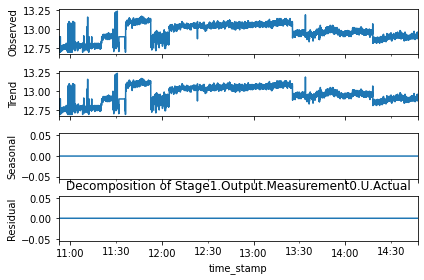

In [ ]:
def decompose(i):
  series = df_stage1_time_index.iloc[:,i]
  result = seasonal_decompose(series, model='additive',extrapolate_trend='freq',freq=1)
  plt.figure(figsize=(8,10)) 
  result.plot()
  plt.title('Decomposition of '+df_stage1_time_index.columns.values.tolist()[i])
  plt.show()

decompose(41)

No significant trend or seasonality is observed in the data.

**Autocorrelation and Partial Autocorrelation**

In [ ]:
def autocorrelation_plot(i):
  plot_acf(df_stage1.iloc[:,i]-np.mean(df_stage1.iloc[:,i]),lags = 40)
  plt.title('Autocorrelation- '+df_stage1.columns.values.tolist()[i])
  plt.show()

Note: The data is centred before plotting the autocorrelations

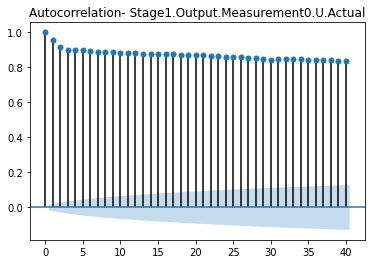

In [ ]:
autocorrelation_plot(42)

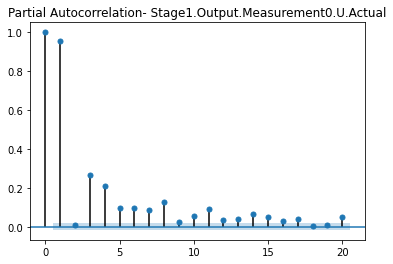

In [ ]:
plot_pacf(df_stage1.iloc[:,42]-np.mean(df_stage1.iloc[:,42]),lags = 20)
plt.title('Partial Autocorrelation- '+df_stage1.columns.values.tolist()[42])
plt.show()


We observe that the acf plot trails off and pacf shows a hard cut-off at lag = 2. This suggests that we use an ARx model with p=1.

# **ARx Model**

In [ ]:
df_stage1 = df_stage1.drop(['time_stamp'],axis = 1)

Split the dataset into to train and test datasets. The temporal order is reserved in the case of time series data.

Moreover, we have standardized our data to ensure a normal distribution.

In [ ]:

X = df_stage1.iloc[:,:41]
y = df_stage1.iloc[:,41]
scaler = StandardScaler()
X = scaler.fit_transform(X,y)
y = (y - np.mean(y))/np.std(y)
X_train = X[0:int(df_stage1.shape[0]*0.8)]
y_train = y[0:int(df_stage1.shape[0]*0.8)]
X_test = X[int(df_stage1.shape[0]*0.8):]
y_test = y[int(df_stage1.shape[0]*0.8):]
print(X_train.shape)  
print(X_test.shape)  
print(y_test.shape)

(11270, 41)
(2818, 41)
(2818,)


In [ ]:
y_train = np.reshape(y_train,(11270))

In [ ]:
y_train.shape

(11270,)

In [ ]:
def arx(p,q,d):
  model = SARIMAX(y_train, exog=X_train, order=(p,q,d), seasonal_order=(0, 0, 0, 0))
  model_fit = model.fit(maxiter=200, solver='newton')
  y_pred = []
  for x in X_test:
    x = np.reshape(x,(1,41))
    yhat = model_fit.predict(len(y_train), len(y_train),exog=x)
    y_pred.append(yhat)
  y_pred = np.reshape(y_pred,(2818))
  NRMSE = np.sqrt(np.sum((y_pred-y_test)**2))/np.sqrt(np.sum((y_test-np.mean(y_test))**2))
  mse = mean_squared_error(y_test,y_pred)
  print('Mean squared error for p = ',p,'is', mse)
  print('Normalized Root Mean Squared error for p = ',p,'is', NRMSE)
  return model_fit, NRMSE,y_pred

We use the Newton Raphson Method to minimize the loss function.

In [ ]:
model_fit, NRMSE,y_pred = arx(1,0,0)

Mean squared error for p =  1 is 3.065318201114577
Normalized Root Mean Squared error for p =  1 is 4.1987719509138755


In [ ]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    Statespace Model Results                                   
===============================================================================================
Dep. Variable:     Stage1.Output.Measurement0.U.Actual   No. Observations:                11270
Model:                                SARIMAX(1, 0, 0)   Log Likelihood               -3540.885
Date:                                 Sat, 20 Nov 2021   AIC                           7167.770
Time:                                         06:30:23   BIC                           7482.956
Sample:                                              0   HQIC                          7273.827
                                               - 11270                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.8971      0.148      6.060      0.000       0.607       1.187
x2            -0.1699      0.048     -3.507      0.000      -0.265      -0.075
x3             0.2671      0.190      1.409      0.159      -0.105       0.639
x4             2.4062      0.686      3.506      0.000       1.061       3.751
x5            -0.3654      0.333     -1.097      0.273      -1.018       0.287
x6            -3.0863      0.609     -5.068      0.000      -4.280      -1.893
x7             0.0058      0.007      0.810      0.418      -0.008       0.020
x8            -0.0157      0.009     -1.777      0.076      -0.033       0.002
x9            -0.0614      0.017     -3.682      0.000      -0.094      -0.029
x10            0.1080      0.021      5.192      0.000       0.067       0.149
x11            0.0973      0.052      1.856      0.063      -0.005       0.200
x12           -0.0333      0.013     -2.556      0.011      -0.059      -0.008
x13            0.6501      0.054     12.078      0.000       0.545       0.756
x14            0.0380      0.091      0.419      0.675      -0.140       0.216
x15        -3.568e+11      0.008  -4.23e+13      0.000   -3.57e+11   -3.57e+11
x16        -1.921e+11      0.008  -2.28e+13      0.000   -1.92e+11   -1.92e+11
x17        -1.998e+11      0.008  -2.37e+13      0.000      -2e+11      -2e+11
x18        -3.492e+11      0.008  -4.14e+13      0.000   -3.49e+11   -3.49e+11
x19            0.0032      0.003      0.997      0.319      -0.003       0.010
x20            0.0211      0.009      2.455      0.014       0.004       0.038
x21           -0.0013      0.007     -0.172      0.863      -0.016       0.013
x22           -0.0217      0.005     -3.992      0.000      -0.032      -0.011
x23           -0.0051      0.003     -1.850      0.064      -0.010       0.000
x24           -0.0012      0.004     -0.318      0.750      -0.009       0.006
x25           -0.7294      0.019    -38.621      0.000      -0.766      -0.692
x26           -0.0193      0.008     -2.356      0.018      -0.035      -0.003
x27        -7.886e+10      0.016  -4.97e+12      0.000   -7.89e+10   -7.89e+10
x28        -6.076e+11      0.026  -2.32e+13      0.000   -6.08e+11   -6.08e+11
x29         6.508e+10      0.015    4.3e+12      0.000    6.51e+10    6.51e+10
x30         5.155e+11      0.030   1.72e+13      0.000    5.15e+11    5.15e+11
x31            0.0033      0.003      0.989      0.322      -0.003       0.010
x32            0.0014      0.013      0.114      0.909      -0.023       0.026
x33            0.0346      0.010      3.590      0.000       0.016       0.053
x34           -0.0009      0.006     -0.156      0.876      -0.012       0.010
x35           -0.0921      0.014     -6.684      0.000      -0.119      -0.065
x36            0.0641      0.028      2.276      0.023       0.009       0.119
x37    

In [ ]:
y_test = np.reshape(y_test,(2818))

**Residual Analysis**

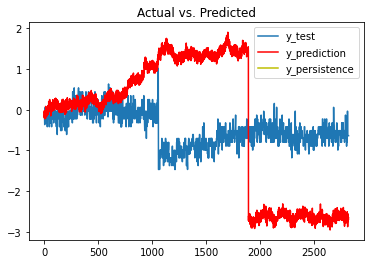

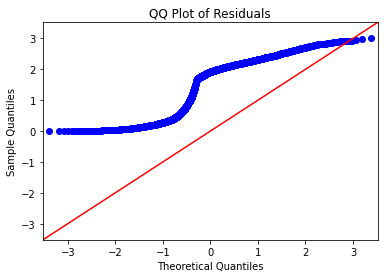

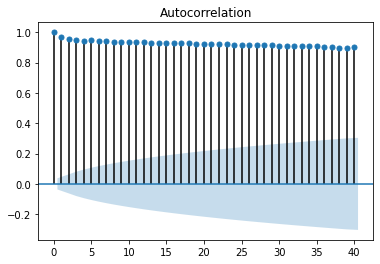

In [ ]:
y_test = np.array(y_test)
df_results = pd.DataFrame({'y_test':y_test, 'y_pred':y_pred})
df_results['Residuals'] = abs(df_results['y_test'] - df_results['y_pred'])
plt.plot(y_test, label = 'y_test')
plt.plot(y_pred, color='red', label = 'y_prediction')
plt.legend()
plt.title('Actual vs. Predicted')
plt.show()
plt.show()
df_results['Residuals'] = np.array(df_results['Residuals'], dtype = float)
sm.qqplot(df_results['Residuals'], line ='45')
plt.title('QQ Plot of Residuals')
plt.show()
plot_acf(df_results['Residuals']-np.mean(df_results['Residuals']),lags = 40)
plt.show()

The residual qq-plot suggests that the residuals are not normally distributed. The autocorrelations suggest that the residuals aren't white noise. 

# **LSTMs**

Add lagged output as an input variable.

In [ ]:
df_output_stage1 = pd.DataFrame()
df_output_stage1['Stage1.Output.Measurement0.U.Actual'] = df_stage1['Stage1.Output.Measurement0.U.Actual']
df_output_stage1.head()

,Stage1.Output.Measurement0.U.Actual
0,12.720000
1,12.896919
2,12.896919
3,12.896919
4,12.896919


In [ ]:
lags = range(1, 2)

df_m0_lagged = pd.concat([df_output_stage1.shift(t, fill_value = 0).add_suffix(f" (t-{t})") for t in lags], axis=1)  # add lags
df_m0_lagged['Stage1.Output.Measurement0.U.Actual'] = df_stage1['Stage1.Output.Measurement0.U.Actual']

In [ ]:
df_stage1 = df_stage1.drop('Stage1.Output.Measurement0.U.Actual', axis = 1)
df_stage1['Stage1.Output.Measurement0.U.Actual (t-1)'] = df_m0_lagged['Stage1.Output.Measurement0.U.Actual (t-1)']
df_stage1['Stage1.Output.Measurement0.U.Actual'] = df_m0_lagged['Stage1.Output.Measurement0.U.Actual']

In [ ]:
df_stage1.head()

,AmbientConditions.AmbientHumidity.U.Actual,AmbientConditions.AmbientTemperature.U.Actual,Machine1.RawMaterial.Property1,Machine1.RawMaterial.Property2,Machine1.RawMaterial.Property3,Machine1.RawMaterial.Property4,Machine1.RawMaterialFeederParameter.U.Actual,Machine1.Zone1Temperature.C.Actual,Machine1.Zone2Temperature.C.Actual,Machine1.MotorAmperage.U.Actual,Machine1.MotorRPM.C.Actual,Machine1.MaterialPressure.U.Actual,Machine1.MaterialTemperature.U.Actual,Machine1.ExitZoneTemperature.C.Actual,Machine2.RawMaterial.Property1,Machine2.RawMaterial.Property2,Machine2.RawMaterial.Property3,Machine2.RawMaterial.Property4,Machine2.RawMaterialFeederParameter.U.Actual,Machine2.Zone1Temperature.C.Actual,Machine2.Zone2Temperature.C.Actual,Machine2.MotorAmperage.U.Actual,Machine2.MotorRPM.C.Actual,Machine2.MaterialPressure.U.Actual,Machine2.MaterialTemperature.U.Actual,Machine2.ExitZoneTemperature.C.Actual,Machine3.RawMaterial.Property1,Machine3.RawMaterial.Property2,Machine3.RawMaterial.Property3,Machine3.RawMaterial.Property4,Machine3.RawMaterialFeederParameter.U.Actual,Machine3.Zone1Temperature.C.Actual,Machine3.Zone2Temperature.C.Actual,Machine3.MotorAmperage.U.Actual,Machine3.MotorRPM.C.Actual,Machine3.MaterialPressure.U.Actual,Machine3.MaterialTemperature.U.Actual,Machine3.ExitZoneTemperature.C.Actual,FirstStage.CombinerOperation.Temperature1.U.Actual,FirstStage.CombinerOperation.Temperature2.U.Actual,FirstStage.CombinerOperation.Temperature3.C.Actual,Stage1.Output.Measurement0.U.Actual (t-1),Stage1.Output.Measurement0.U.Actual
0,17.24,23.53,11.54,200,963.0,247,1241.26,72.0,72.3,48.03,10.48,436.76,76.3,75.1,12.59,236,601.11,257,200.75,69.37,69.06,73.25,13.89,246.68,68.8,60.1,9.02,186,421.16,200,203.95,78.2,78.4,337.40,13.50,263.71,65.3,65.0,99.1,108.2,80.0,0.000000,12.720000
1,17.24,23.53,11.54,200,963.0,247,1246.09,72.0,72.3,48.03,10.48,436.77,76.3,75.1,12.59,236,601.11,257,220.16,69.35,69.05,73.19,13.89,246.02,69.0,60.0,9.02,186,421.16,200,213.36,78.1,78.4,341.85,13.59,262.88,65.3,65.0,99.1,109.2,80.0,12.720000,12.896919
2,17.24,23.53,11.54,200,963.0,247,1246.29,72.0,72.3,48.16,10.48,425.46,76.3,75.1,12.59,236,601.11,257,216.84,69.37,69.07,73.19,13.85,247.18,68.9,60.0,9.02,186,421.16,200,225.25,78.1,78.5,338.71,14.00,262.63,65.3,65.0,99.6,111.0,80.0,12.896919,12.896919
3,17.24,23.53,11.54,200,963.0,247,1247.59,72.0,72.3,48.57,10.48,437.01,76.3,75.1,12.59,236,601.11,257,208.61,69.38,69.08,72.81,13.90,249.92,69.1,59.9,9.02,186,421.16,200,213.99,78.1,78.5,339.15,13.67,262.22,65.4,65.0,99.6,109.2,80.0,12.896919,12.896919
4,17.24,23.53,11.54,200,963.0,247,1252.83,72.1,72.4,48.57,10.48,425.18,76.4,75.1,12.59,236,601.11,257,212.31,69.40,69.07,73.00,13.89,250.58,68.9,59.9,9.02,186,421.16,200,200.86,78.0,78.5,337.05,13.72,262.17,65.4,65.0,99.6,109.8,80.0,12.896919,12.896919


In [ ]:
X = df_stage1.iloc[:,:42]
y = df_stage1.iloc[:,42]
scaler = StandardScaler()
X = scaler.fit_transform(X)
y = (y - np.mean(y))/np.std(y)
X_train = X[0:int(df_stage1.shape[0]*0.8)]
y_train = y[0:int(df_stage1.shape[0]*0.8)]
X_test = X[int(df_stage1.shape[0]*0.8):]
y_test = y[int(df_stage1.shape[0]*0.8):]
print(X_train.shape)  
print(X_test.shape)  
print(y_test.shape)

(11270, 42)
(2818, 42)
(2818,)


In [ ]:
X_train = np.reshape(X_train,(11270,1,42))
X_test = np.reshape(X_test,(2818,1,42))
print(X_train.shape)
print(y_train.shape)

(11270, 1, 42)
(11270,)


In [ ]:
def rmse(y_true, y_pred):
	return backend.sqrt(backend.sum(backend.square(y_pred - y_true)))

model = Sequential()
model.add(LSTM(26,activation='tanh',input_shape=(1,42),bias_initializer='he_normal')) #
model.add(Dropout(0.2, input_shape=(1,1)))
model.add(Dense(1, activation='relu',bias_initializer='he_normal'))

model.compile(loss='mean_squared_error', optimizer= 'adam',metrics=[rmse])
print(model.summary())
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=10, verbose=2)

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_37 (LSTM)              (None, 26)                7176      
                                                                 
 dropout_33 (Dropout)        (None, 26)                0         
                                                                 
 dense_35 (Dense)            (None, 1)                 27        
                                                                 
Total params: 7,203
Trainable params: 7,203
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
1127/1127 - 5s - loss: 0.7560 - rmse: 2.6002 - val_loss: 2.2691 - val_rmse: 4.3611 - 5s/epoch - 5ms/step
Epoch 2/50
1127/1127 - 3s - loss: 0.6530 - rmse: 2.4130 - val_loss: 1.8323 - val_rmse: 3.8782 - 3s/epoch - 3ms/step
Epoch 3/50
1127/1127 - 3s - loss: 0.6485 - rmse: 2.3853 - val_loss: 1.6945 - v

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'rmse', 'val_loss', 'val_rmse'])


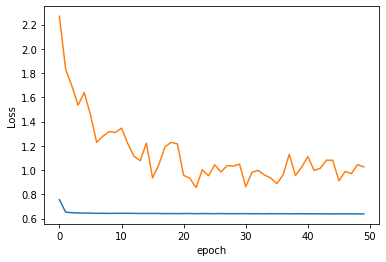

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.show()

The model overfits the data in this case.

In [ ]:
y_pred = []
for x in X_test:
  x = np.reshape(x,(1,1,42))
  yhat = model.predict(x, verbose=0)
  y_pred.append(yhat)

In [ ]:
y_pred = np.array(y_pred)
y_pred = np.reshape(y_pred,(2818))
y_pred.shape

(2818,)

In [ ]:
rmse_test =  np.sqrt(np.sum((y_pred-y_test)**2)/y_test.shape[0])
nrmse_test = np.sqrt(np.sum((y_pred-y_test)**2))/np.sqrt(np.sum((y_test-np.mean(y_test))**2))
print('Root Mean Squared error is', rmse_test)
print('Normalized Root Mean Squared error is', nrmse_test)
# print('Fit % for ARX model is ',100*(1-nrmse_test))

Root Mean Squared error is 1.013216242916001
Normalized Root Mean Squared error is 2.429890195724437


In [ ]:
def rmse(y_true, y_pred):
	return backend.sqrt(backend.sum(backend.square(y_pred - y_true)))
model = Sequential()
model.add(LSTM(20,activation='tanh',input_shape=(1,42),bias_initializer='he_normal')) #, activity_regularizer='l1'
model.add(Dropout(0.2, input_shape=(1,1)))
model.add(Dense(1, activation='relu',bias_initializer='he_normal'))

model.compile(loss='mean_squared_error', optimizer= 'adam',metrics=[rmse])
print(model.summary())
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=10, verbose=2)
#validation split can't be done in case of time series, temporal order is important

Model: "sequential_58"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_61 (LSTM)              (None, 20)                5040      
                                                                 
 dropout_55 (Dropout)        (None, 20)                0         
                                                                 
 dense_58 (Dense)            (None, 1)                 21        
                                                                 
Total params: 5,061
Trainable params: 5,061
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
1127/1127 - 5s - loss: 0.7759 - rmse: 2.6421 - val_loss: 2.4030 - val_rmse: 4.4400 - 5s/epoch - 4ms/step
Epoch 2/50
1127/1127 - 2s - loss: 0.6545 - rmse: 2.4136 - val_loss: 2.1717 - val_rmse: 4.1887 - 2s/epoch - 2ms/step
Epoch 3/50
1127/1127 - 2s - loss: 0.6490 - rmse: 2.3880 - val_loss: 2.0651 - v

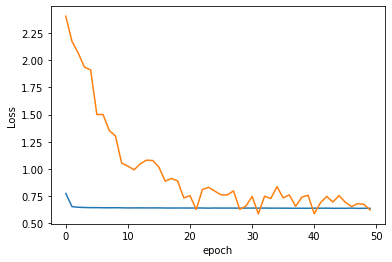

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.show()

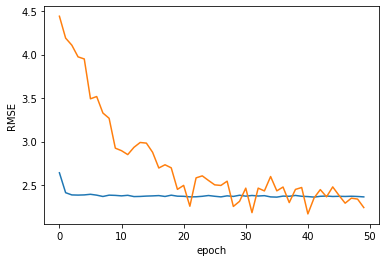

In [ ]:
rmse = np.array(history.history['rmse'])
val_rmse = np.array(history.history['val_rmse'])
plt.plot(rmse)
plt.plot(val_rmse)

plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.show()

In [ ]:
y_pred = []
for x in X_test:
  x = np.reshape(x,(1,1,42))
  yhat = model.predict(x, verbose=0)
  y_pred.append(yhat)

In [ ]:
y_pred = np.array(y_pred)
y_pred = np.reshape(y_pred,(2818))
y_pred.shape

(2818,)

In [ ]:
rmse_test =  np.sqrt(np.sum((y_pred-y_test)**2)/y_test.shape[0])
nrmse_test = np.sqrt(np.sum((y_pred-y_test)**2))/np.sqrt(np.sum((y_test-np.mean(y_test))**2))
print('Root Mean Squared error is', rmse_test)
print('Normalized Root Mean Squared error is', nrmse_test)

Root Mean Squared error is 0.7896724818806247
Normalized Root Mean Squared error is 1.8937886507156885


This model fit decently on our time series. We shall visualize the model as follows:

In [ ]:
#visualize models
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='drive/MyDrive/CL688Project/MultistageContinuousFlowProcess/model_plot.png', show_shapes=True, show_layer_names=True)
plt.show()